## Using Sequence Models to do Exon Calling in TF2.0

CpG islands were kind of a simple problem that the sequence models were basically too overpowered to do a very good job with, so for this demo, maybe we can do something more interesting.

In eukaryotic cells, the transcripts produced by RPolII aren't the final messanger RNA, but rather pre-mRNA, that then gets processed by the [Spliceosome](https://en.wikipedia.org/wiki/Spliceosome), producing the final mRNA that then gets translated by ribosomes.

[Wikipedia](https://en.wikipedia.org/wiki/RNA_splicing) has a pretty good picture of this process.

![title](images/splicesome.png)

## Recap

Last time we built a convolutional neural network to predict CpG islands, then looked at some of the other architectures people use for sequence prediction.

Today, we'll look at practical sequence models, and how they apply to the problem of exon calling and splice prediction.

Useful links:

* [Tensorflow Docs](https://www.tensorflow.org/tutorials/)
* [Keras Docs](https://keras.io/)
* [Seq2Seq in Tensorflow 2.0](https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/)
* [Seq2Seq Paper](https://arxiv.org/abs/1409.3215)
* [Luong Attention Paper](https://arxiv.org/abs/1508.04025)

Hopefully ready for next time:

* [Transformer in Tensorflow 2.0](https://machinetalk.org/2019/04/29/create-the-transformer-with-tensorflow-2-0/)
* [Transformer Paper](https://arxiv.org/abs/1706.03762)

## Imports

We can use the same libraries as last time

In [133]:
# Standard lib
import itertools
from collections import Counter

# 3rd party libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
assert tf.__version__.startswith('2.')

In [2]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
GPU is NOT AVAILABLE


## Exon Data

I took the first 10,000 genes from the GRCh38 human genome, chopped out every section labeled `transcript` then marked all the parts within labeled `exon` or `intron` as `E` or `I` respectively.

In [3]:
raw_data_gene = []
raw_data_seq = []
raw_data_cls = []

with open('short_transcripts.txt', 'rt') as fp:
    gene, seq, cls = None, None, None
    for line in fp:
        if line.startswith('#'):
            if seq is not None and cls is not None:
                raw_data_gene.append(gene)
                raw_data_seq.append(seq)
                raw_data_cls.append(cls)
            seq, cls = None, None
            gene = line.split(' ', 1)[1].strip()
            continue
        line = line.strip()
        if seq is None:
            seq = line
        elif cls is None:
            cls = line
        

In [4]:
print(raw_data_gene[104])

HES4


In [5]:
print(raw_data_seq[104])

TCTGGAATAATAAATACGTTTTCTCTGCTACAGTCTCGGCAAAGGCCACGGCCCTAGAACGGGGCGCCGCCTCCGATGCAGTCTCAGGGCCACAGCCTCAGCGCAGCCACGGCCTCCAGGGCCCACCCGGGCCCTGCGGCCCCGCCCTGGGGGCGGCGGGCAGCGCCCGGGTCAGACCCGGCAGCAGCGGCGGCGCGAGCAGAGGGAAGGGGCCGCCGAGCGATGGCAGCAGCGGGCGGCCCGCGTAGACCTCGGGCGCTGGGGCCTCTGCGGGGGCAGCCGGGGACAGCGAGGCCGGGCGGCGGGAGGGTCCCAGCTGGCGCAGGCAGGCTGCCAGGTGGCCCAGCAGGCGGGAGCGCACGTCGGCCGGGACGCCCTCGCAGCCGGCCAGGAAGCGGTTCACCTCCGCCAGACACTCGTGGAAGCCGGCGCGGTACTTGCCCAGAACGGCGGGGTCGGCGCTGAGCGCGGCTGCGGGAGCGACACAGGAGGAGAGGTCGGTGCCGGGTCCCGGGGGTCCCGCGCCCTCCCCCCGCCTCCAAGCCGCCGCCGCCCGCGCCTCACCCGTCACCTGCACGCGACGCAGGCTCCGCAGGTGTCTCACGGTCATCTCCAGGATGTCCGCCTTCTCCAGCTTCGAGTGGCGGGAGCTCTGGGGGCGGGGATAGGCGGGAGGTCCAGGTCAGCTGCGACCCAGACTCCGGGTCTCGGGCCTTCGCCCCCGACTTACCTCTTTTCTGAGGGCGTCCAGGATGAGGGTTTTGAGCTGAGCGAGGCTCTCGTTAATACGCGCTCGGCGCCGCTTCTCCATGACCGGCTTGGAGGACTGCGGGTCGGGCACCGGCTGAGTCCCGCGTCCCTCCCGCCCCCCGGTCGCCCCCCTCACGCCCGGCCGGGACCCCACCTTGCGGTGCTCGGCCGCGCTCCGGGGCTTGTCTGGGGTCCGGCTGGCGCTGGCCGGCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGT

In [6]:
print(raw_data_cls[104])

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

We need to hack with the data a bit to make keras's native tokenizer work with it, specifically by spliting each record into k-mers

In [7]:
# This should probably be larger, like 9 or 11, but for demo purposes...
NUM_K: int = 6

def split_into_kmers(raw_seq: str, raw_cls: str, k: int = NUM_K):
    """ Split a sequence into padded k-mers """
    seq_kmers = []
    cls_kmers = []
    for i in range(0, len(raw_seq), k):
        seq_kmers.append(raw_seq[i:i+k])
        cls_kmers.append(raw_cls[i:i+k])
    if len(seq_kmers[-1]) < k:
        seq_kmers[-1] = seq_kmers[-1] + 'X'*(k-len(seq_kmers[-1]))
        cls_kmers[-1] = cls_kmers[-1] + 'X'*(k-len(cls_kmers[-1]))
    return ' '.join(seq_kmers), ' '.join(cls_kmers)


In [39]:
# Reduce the dataset size so it runs on a laptop
kmer_data = [split_into_kmers(seq, cls) for seq, cls in zip(raw_data_seq, raw_data_cls)
             if len(seq) < 2000]
print(len(kmer_data))

788


In [9]:
kmer_data[104]

('TGAGGT TGTTGG GAAAAA TTTAAT CAGCTA CAGATA TTTTAA GTACCA AAGGCT GCCTCT GGAGGG AAAAGA AAACTA CCCCTC TGGTTC TGGTTG ACAGAA GTATGT ATTATC AGATTC CCTGTG AGGCTT TACATC CCATGT TTGCTG GAGAAC AGAGGG ATTCTC TAAGAG TGTAGT GATTTC TTCAGA TAGTTC CTTCAT CTTGCC TTCAAT TATTTC AGAGGC TTAAAA GAAAAG AATATA AATATT AGCAAC ACCAGG AACTGA ATAATA CAAGTC TTTCAA TATCTC CAGCTA ACCTTT GCACCA TTTTGG CTTGCT CCAAAG GGTCTC CATGTT TGAGGC AAAACT AAATAG ACACAG CTTTGC ATCTTC CCTGAT AAACAT GAAGAG ACCTCA CAGGAA AGCAAT GAACAC TTTACA AGTCTT CCAAAA GCTGCT GTCTCT GCTAAA GAACAG CTTATA CAAGTC AAGGCC TGCCAT AATGCC TAGGGC AATCCA GGCACT ATCTGC CACTGA GCATAA ATTTAC TGAAGC TATCCA GGCTGG TATTCT CTCTAA TAGTGC ATAATA GAGCAA TGGAAA AATAAG CTGCCC TTGGAC ACTAAG CCTGTC TCTTGC ATCTCC CTACAA AGAAAT CAAATA CTATTT TATTTT ATTTTA TTTTAT GTTTTA TTTTAT TTTAAT TTTATT TTATAC AAATCC AAGGAA ATCTGC TCTTCT ATGAGT GGCCTA GACCAG GGATCA GCAAAC TGTTTT TGTAAA TAAAAT TTTATT GGAACA CAGCCA TGCTTG TTCACT TACATA TTGTCT ATGGTT GCTTTC CTGCTA CAACAG CAGAAT TGAGTA GTTG

We need to add a special token to the output sequence to mark the beginning (`<start>`) and the end (`<end>`)

In [10]:
seq_data, cls_data = zip(*kmer_data)
seq_data = list(seq_data)
cls_data = list(cls_data)

In [11]:
cls_data_in = ['<start> ' + cls for cls in cls_data]
cls_data_out = [cls + ' <end>' for cls in cls_data]

In [12]:
seq_data[2:5]

['CAGCTC CTGAGA CTGCTG GCATGA AGGGGA GCCGTG CCCTCC TGCTGG TGGCCC TCACCC TGTTCT GCATCT GCCGTG AGTCTG TGCCAC TGGGGT TTCCAG AACATT CAGGGG TGGGGG GGAGTG GGGGGT ACCTGA GAAGGT AAAATC CTGGCA TCGGGC CTCTGC AGTGAA CACTCC ACCTGC TTCTGT CACAGA AGTGGG CAAGGA CCCTGC AGAACC CGCGCC CACCCT ACTCCA CCCCAA CCAAGG ACAAAG CCCAGC TGACCC AACACC AGCCCA GTGTCT CCTACC CCAGCC CAGTCC AGCCTG ACCTGA CCCTTC AAGCCT CTGGTC ATAATA GCCTCT CATCAG GGGAAA TTTCCC CCACAC CAGGAG CTTAAC TTTCCT TCCCTG GTGATC CCAGGG AATGCT GAGTGG AAATTG GAGCAG CTAAGA TTAAGG GGGATG TGGAGG GGTCTT CGGGCA AGGTGG AGTTGG AGGTGT TGTGGA GGAAGC CCTGGG GAGGAG AGGTGG GCATTG AAGGGG AAGGTC TGGAGA CCATGG AGGTTG GAGCCC TGGGGC AGGTCC AGGGCT GTGGTT GCACCA GAGTCA CCCTGT CCTGTC CTGGCA TCATCT CGCTCG TGATGC AGGGAT GGCCAC AGGGGA GGACAA CGATGA GTTTTT CATGGA CTTCCT GCAAAC ACTACT GGTGGG GACCCC AGAGGA GCTCTA TGAGGG GACCTT GGGCAA GTACAA TGTCAA CGAAGA TGCCAA GGCAGC AATGAC TGAACT CAAGTC CTGTAT AGATGG CCTGCA GCCAAT GCACAA GGCGGA GCTGGT CAAGCT GCTGGT ATGAGG GCGGCG GGCACC CCAT

In [13]:
cls_data_in[2:5]

['<start> EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEII IIIIII IIIIII III

In [14]:
cls_data_out[2:5]

['EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEII IIIIII IIIIII IIIIII IIII

Basically, `cls_data_in` and `cls_data_out` are identical, but phase shifted by one token

Now we can use the NLP tools built into keras, but for our sequence data

In [15]:
seq_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
# Careful, by default filters strips out ?.!
seq_tokenizer.fit_on_texts(seq_data)

In [16]:
# Note that by increasing or decreasing k, you drastically change this table
print(len(seq_tokenizer.word_index))

4373


In [17]:
# What's actually in the table? It's just a dense index over k-mers
for i, (k, v) in enumerate(seq_tokenizer.word_index.items()):
    print(k, v)
    if i > 10:
        break

aaaaaa 1
tttttt 2
aaaaat 3
gggagg 4
cagcag 5
attttt 6
cccagg 7
cctccc 8
caggag 9
ggctgg 10
taaaaa 11
aaaata 12


In [18]:
cls_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
# If you fit on multiple texts, it just updates the database
cls_tokenizer.fit_on_texts(cls_data_in)
cls_tokenizer.fit_on_texts(cls_data_out)

In [19]:
# Of course the clasification has a much smaller index
print(len(cls_tokenizer.word_index))

28


Cool, now we have a tokenization scheme, so we can convert tokens to token indices

In [20]:
# Turn the k-mers into k-mer indices
seq_idx = seq_tokenizer.texts_to_sequences(seq_data)

In [21]:
print(seq_idx[2])

[114, 617, 20, 2306, 804, 2564, 119, 180, 756, 700, 618, 1601, 2564, 1549, 590, 160, 454, 1022, 326, 137, 864, 771, 1219, 1220, 357, 424, 2971, 252, 772, 677, 407, 566, 392, 487, 338, 82, 1847, 2362, 1140, 491, 616, 1053, 379, 27, 1512, 2123, 746, 1602, 1186, 40, 839, 83, 1219, 701, 747, 492, 1352, 434, 1702, 489, 796, 567, 9, 2872, 177, 194, 1513, 121, 1703, 418, 1259, 136, 2192, 2124, 900, 324, 1550, 2363, 199, 2125, 1221, 967, 702, 25, 92, 199, 1965, 1092, 2517, 104, 658, 1353, 840, 308, 2022, 420, 1057, 989, 1966, 647, 437, 424, 673, 3940, 2250, 1962, 508, 804, 1659, 3611, 285, 1514, 192, 2873, 2615, 49, 1023, 251, 2925, 703, 1756, 1461, 2722, 2193, 2972, 1757, 171, 1915, 1704, 2194, 2126, 527, 280, 2818, 1515, 2254, 358, 344, 358, 1058, 2023, 1183, 704, 1187, 1412, 18, 2519, 897, 1462, 568, 567, 2616, 130, 270, 2024, 1516, 392, 1141, 3100, 2025, 114, 199, 1097, 1517, 696, 1967, 144, 44, 491, 3342, 61, 1603, 619, 2819, 841, 805, 1024, 2127, 408, 2454, 549, 941, 1663, 1551, 281, 207

In [22]:
cls_idx_in = cls_tokenizer.texts_to_sequences(cls_data_in)
cls_idx_out = cls_tokenizer.texts_to_sequences(cls_data_out)

In [23]:
print(cls_idx_in[2])
print(cls_idx_out[2])

[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 2, 2, 2, 2, 2, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Cool, assuming everything is correct, `cls_idx_in` and `cls_idx_out` are still just the same sequence shifted by one token (apparently `10` is `<start>` and `11` is `<end>`).

One last trick: we need to pad all the sequences to the same length

In [24]:
seq_idx = tf.keras.preprocessing.sequence.pad_sequences(seq_idx,
                                                        padding='post')

In [25]:
print([len(s) for s in seq_idx[:10]])

[333, 333, 333, 333, 333, 333, 333, 333, 333, 333]


In [26]:
cls_idx_in = tf.keras.preprocessing.sequence.pad_sequences(cls_idx_in,
                                                           padding='post')
cls_idx_out = tf.keras.preprocessing.sequence.pad_sequences(cls_idx_out,
                                                            padding='post')

In [27]:
print([len(s) for s in cls_idx_in[:10]])
print([len(s) for s in cls_idx_out[:10]])

[334, 334, 334, 334, 334, 334, 334, 334, 334, 334]
[334, 334, 334, 334, 334, 334, 334, 334, 334, 334]


The data is finally sort of matrix-shaped, so we can hand it to `tensorflow` as a `Dataset`, which automagically handles splitting, batching, etc

In [55]:
BLOCK_SIZE = 100
BATCH_SIZE = 5

dataset = tf.data.Dataset.from_tensor_slices(
    (seq_idx, cls_idx_in, cls_idx_out))

# Shuffle transcripts, taking them in blocks of 1,000, with a batch size of 5
dataset = dataset.shuffle(BLOCK_SIZE).batch(BATCH_SIZE)

In [56]:
print(dataset)

<BatchDataset shapes: ((None, 333), (None, 334), (None, 334)), types: (tf.int32, tf.int32, tf.int32)>


## Model 1: Naive Sequence Model

The first model is just the basic sequence framing. We try to predict a sequence with a shift of 1 from the input alone.

In [30]:
# Encoder/Decoder fusion model
# Embedding followed by an LSTM, followed by a decoder
class SeqEncoderDecoder(tf.keras.Model):
    def __init__(self,
                 in_vocab_size: int,
                 out_vocab_size: int,
                 embedding_size: int,
                 lstm_size: int):
        super(SeqEncoderDecoder, self).__init__()
        
        # Sizes for matrices
        self.lstm_size = lstm_size
        self.in_vocab_size = in_vocab_size
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        
        # Layers
        # Embed the input vocab in a smaller embedding space
        self.embedding = tf.keras.layers.Embedding(
            in_vocab_size, embedding_size)
        # Stateful layer, generate both outputs and internal states
        self.lstm = tf.keras.layers.LSTM(
            lstm_size, return_sequences=True, return_state=True)
        # Finally decode back onto the output vocab size
        self.dense = tf.keras.layers.Dense(out_vocab_size)
        
    def call(self, sequence, state):
        """ Call for a single step, output as single step """
        # Input -> embedding
        embed = self.embedding(sequence)
        # Embedding -> LSTM
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
        # Next stage of LSTM + output
        logits = self.dense(lstm_out)
        return logits, state_h, state_c
    
    def init_states(self, batch_size: int):
        """ Initial states for a batch
        
        Set the hidden state and the output state to all 0s
        """
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

Build the actual model

In [57]:
EMBEDDING_SIZE = 32
LSTM_SIZE = 64

seq_vocab_size = len(seq_tokenizer.word_index) + 1
cls_vocab_size = len(cls_tokenizer.word_index) + 1

# Build the encoder/decoder model
enc_dec = SeqEncoderDecoder(seq_vocab_size, cls_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)

Send in a test input and make sure the sizes of things make sense

In [58]:
source_input = tf.constant([[1, 3, 5, 7, 2, 0, 0, 0]])
initial_state = enc_dec.init_states(1)

enc_output, enc_state_h, enc_state_c = enc_dec(source_input, initial_state)

print('Source vocab size', seq_vocab_size)
print('Source sequences', source_input.shape)
print('Encoder outputs', enc_output.shape)
print('Encoder state_h', enc_state_h.shape)
print('Encoder state_c', enc_state_c.shape)

Source vocab size 4374
Source sequences (1, 8)
Encoder outputs (1, 8, 29)
Encoder state_h (1, 64)
Encoder state_c (1, 64)


For a loss, we can do cross entropy. But we also need to be careful to avoid penalizing the padded parts of the sequence.

In [59]:
def loss_func(targets, logits):
    """ cross entropy ignoring the padding """
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

Optimize using Adam, because Adam always works pretty okay

In [60]:
optimizer = tf.keras.optimizers.Adam()

### Training

Tensorflow 2.0 has a magic autogradient method called the `GradientTape` which can capture all the tensor operations inside a function, back out all the gradients, and then solve the chain rule for you. Magical!

In [61]:
# Training step
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    # Record all the operations in the forward pass
    with tf.GradientTape() as tape:
        en_outputs = enc_dec(source_seq, en_initial_states)
        logits = en_outputs[0]
        # Expand the output sequence into 1-hot encoding
        target = target_seq_out[:, :-1]
        loss = loss_func(target, logits)
    
    # Work out the gradients automagically
    variables = enc_dec.trainable_variables
    gradients = tape.gradient(loss, variables)
    
    # Optimize
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

### Prediction

For prediction, we just pass the input in and hope...

In [75]:
# Prediction step
def predict(test_seq=None):
    """ Predict on the source sequence only """
    if test_seq is None:
        test_seq = seq_data[np.random.choice(len(seq_data))]
    elif isinstance(test_seq, int):
        test_seq = seq_data[test_seq]
    test_seq_idx = seq_tokenizer.texts_to_sequences([test_seq])
    
    # Initialize the encoder and generate the forward state
    seq_initial_states = enc_dec.init_states(1)
    enc_outputs = enc_dec(tf.constant(test_seq_idx), seq_initial_states)[0]
    
    out_score = tf.argmax(enc_outputs[0, ...], axis=-1).numpy()
    out_kmers = [cls_tokenizer.index_word[i] if i in cls_tokenizer.index_word else 'X'*NUM_K
                 for i in out_score]
    print('')
    print(test_seq)
    print(' '.join(out_kmers))
    print('')
    return out_kmers

In [77]:
# Predict on the untrained model to make sure it does a thing
predict();


CGCCCT CAAACA ACCAGT CAAAGT CTTCTC CATTAA GATTAT CAGCTT TGGGAT AACCAA TTTTTT TTAATG TTTCCA CAAACT CATTTC CACAAC TCATGG TTTTAA CTACCC CAATTT TGTTGT ATCTGA TATGGG TTTACG GTGTTG ATTTTT AGAAAA TAAATC CAAGCA GAAAAA AAGCTA CGTTTT ATACCA AGTCCA CAGAGA AGGGAA AATATA TTTTTA GAATCT ATAATG ATTCCT CCTAGG GGGGAA GAAAAC AAGTAT TAGACC ACAAAT ATGACG ACAGTG TTTTTA AAAAGA AGACAC AGACAA ATATCA CATGAT ATCCGA GAGCGG GATAAA TGACAG GTAGTC GTAGCT GCAATG TTTGAT GATGAT AAAGAG AAACAG AAACAA TTAGGC TAGTTC TCAGAA AACCGC AACAGT AACGAA AAGTAA TTAACA AGAAAG TGGATC TATTTG GATCCA TTTTAT CTTTTT TTCCAA AGATAA AATGGT TTAAAA TGCATT ACACTT TATAGA GCAGCA TTTGTT TTTAAT TCAAAA TAAATG GATCCA AACAAA CCCAAG CCACCA GGAGGC TAGGCA GCCTCT CTTCCC TGCCCT CCGTAC GTAAGA AGACGC AAATAA GCATGG CACATC TTCTGA AGATCA ACTAAA TATTTA CCTCAA CGTCTC GCCGGG CAAGGC TCCACC TCCAGA GTCCAC CACCGC GACGCG GAGAAC AGCAGG AGCAGC AGGGAA GCGCGC GGCCAC AATTAA GGGTGC TTCGGG CCGGCC TTCAGC CAGCGC TGAGGC AGCCCC GACGCC AGGGCC GCGCGA ACCCCA GAGGCA GCGGCA AGCCCC AGGGA

### Training loop

In [70]:
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        enc_initial_states = enc_dec.init_states(source_seq.shape[0])
        loss = train_step(source_seq, target_seq_in, target_seq_out, enc_initial_states)
        print(loss.numpy())
    print(f'Epoch {epoch+1} Loss {loss.numpy():.4f}')
    
    try:
        predict();
    except Exception:
        continue

0.34924662
0.38295937
0.318132
0.27396616
0.3240919
0.36765364
0.36805332
0.33588427
0.42058823
0.37192908
0.38659108
0.4680552
0.3650541
0.26808432
0.33962733
0.36672294
0.3024968
0.3674227
0.24329516
0.417697
0.4290935
0.29634416
0.44853368
0.3872811
0.34016022
0.3701311
0.36340538
0.3725462
0.40783462
0.30656648
0.29142645
0.3825042
0.41786903
0.49387482
0.35500452
0.37183547
0.39814764
0.3834224
0.43434173
0.36984035
0.34237364
0.49055374
0.3610029
0.32147327
0.52348316
0.33014265
0.40120086
0.4760288
0.37663618
0.43994895
0.30760965
0.33715203
0.3829675
0.41749173
0.49310526
0.35018975
0.28204048
0.43157429
0.37286916
0.25129375
0.4450146
0.47923273
0.29233798
0.29153058
0.2771438
0.40619758
0.39219067
0.3957338
0.31603482
0.48270357
0.32254517
0.3305024
0.34674978
0.32428008
0.37988737
0.29551786
0.4537161
0.37046242
0.35148403
0.3841143
0.41653603
0.47721848
0.38496694
0.56313694
0.3626288
0.4883033
0.3610372
0.3968038
0.46488285
0.34783173
0.48100153
0.39034322
0.47594932
0.533

How well did it do?

In [78]:
pred_seq = predict(25)
print(' '.join(cls_data_in[25].split(' ')[1:]))


TCTAGG TGCAAC AATCAA GCTCTA TTTTTG TAATTA AAAATG TATCCA AAGGGA AAAAAG AAACAA AAGGAA CAATAT TTGTAC TCTATG TTGCTG CAGAGA GCAGAA CTGCGG AGGGGG TGCTAG TCCCAA GGGGTG GACTGT GCTGTG CTAGTG CCCTAA ATCCTG CAAGCG CGGGGT TGGGGG GGCGGG GGAGAC CGCTGT CGGGGG TCGTGA GTTCCG GGCCCT TGTGTG CATGTT CACGTC CTGTCA TTCTTG CCCCCA GCTGAG AGAGCA GTAGAG GAAAGG CACTAC ATCCAC CAGCCT TTGCAT TCTCCT CGGAGC ACACAG AAAGAC ATTTTC CAGTTA TCTTGC ACACAA GTGGGC GGCGGG ACCCGT TTTGGC CGGGAA CGTTGT CAGGAA CGCTGT ACACCA CTTCCA GGCGGT CACGTC CGAGCT GCCCAG GCAGTC CTTCTG CGCCCT CTGCTG GCCAGA TGGAGG CTGCAG ACCCTG CGGGGC CATCAG GAGAGA ACCACC AAGCAC CCTCTG CACACC GCATTG CCTGTG TTGGGC ACAAAG AATAAA CTTTTA TTGCAT CTTAAC CCACTA GAAATG TAGGCT TGTCCA TCACAG TGGGGC GTTACA TACCCT AATACA TAGGGA AGGCAT AGGTAG ATTTCA GTTGGC CTTTTA CAGACA AGGAAA CCAAGG CTTGAG AAGATT CAAACC TTACTG CAGCCA TGGCTC ACACCT ATATAC CCTCAG TACTTT GGGAGA CCAAGG CAGGTG GCTCGC TTGAGC CCAGGA GTTCCA GACAAG CCTGGG CAACAT AGAGAA ACCCCA TCTCTA CGAATA TTTTTT AAATTA GCTGGG TGTGG

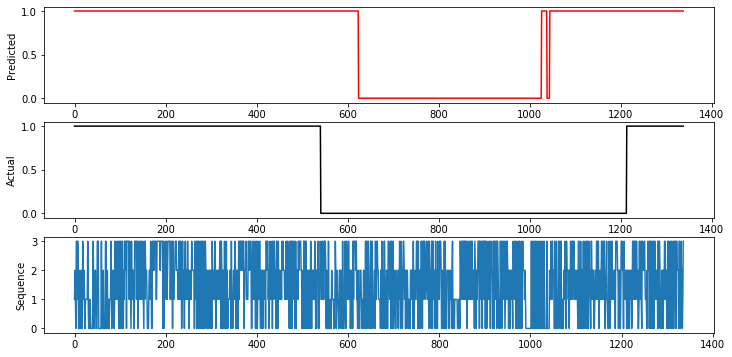

In [87]:
# Plot it in matplotlib
CODES = {
    'A': 0,
    'T': 1,
    'C': 2,
    'G': 3,
    'X': np.nan,
}

input_seq = np.array([CODES[s.upper()] for s in ''.join(seq_data[25].split(' '))])

pred_seq_values = np.array([0 if s.lower() == 'i' else 1 for s in ''.join(pred_seq)])
exp_seq_values = np.array([0 if s.lower() == 'i' else 1 for s in ''.join(cls_data_in[25].split(' ')[1:])])

x = np.arange(pred_seq_values.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))
ax1.plot(x, pred_seq_values, color='r')
ax1.set_ylabel('Predicted')
ax2.plot(x, exp_seq_values, color='k')
ax2.set_ylabel('Actual')
ax3.plot(x, input_seq)
ax3.set_ylabel('Sequence')
plt.show();

## Model 2: Seq2Seq Model

Seq2seq splits the model into an encoder stage, which processes the input sequence, and a decoder stage, which tries to generate the output sequence, using the previous outputs as context to generate the next step

In [88]:
# Encoder model
# Has an embedding layer, and then a set of states
class SeqEncoder(tf.keras.Model):
    def __init__(self, vocab_size: int, embedding_size: int, lstm_size: int):
        super(SeqEncoder, self).__init__()
        self.lstm_size = lstm_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        
        # Layers
        # Embedd a vocab in a smaller embedding space
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_size)
        # Stateful layer, generate both outputs and internal states
        self.lstm = tf.keras.layers.LSTM(
            lstm_size, return_sequences=True, return_state=True)
        
    def call(self, sequence, state):
        """ Call for a single step, output as single step """
        # Input -> embedding
        embed = self.embedding(sequence)
        # Embedding -> LSTM
        output, state_h, state_c = self.lstm(embed, initial_state=state)
        # Next stage of LSTM + output
        return output, state_h, state_c
    
    def init_states(self, batch_size: int):
        """ Initial states for a batch
        
        Set the hidden state and the output state to all 0s
        """
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

In [89]:
# Decoder model
# Takes the output from the encoder and writes out the final word
class SeqDecoder(tf.keras.Model):
    
    def __init__(self, vocab_size: int, embedding_size: int, lstm_size: int):
        super(SeqDecoder, self).__init__()
        self.lstm_size = lstm_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        
        # Layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(
            lstm_size, return_sequences=True, return_state=True)
        # New layer, map output of the lstm back onto the original vocab
        self.dense = tf.keras.layers.Dense(vocab_size)
    
    def call(self, sequence, state):
        embed = self.embedding(sequence)
        lstm_out, state_h, state_c = self.lstm(embed, state)
        logits = self.dense(lstm_out)
        return logits, state_h, state_c

Now we have two stages, so make sure they're compatible

In [92]:
# Generate a model and check for typos
EMBEDDING_SIZE = 32
LSTM_SIZE = 64

encoder = SeqEncoder(seq_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)

decoder = SeqDecoder(cls_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)

source_input = tf.constant([[1, 3, 5, 7, 2, 0, 0, 0]])
initial_state = encoder.init_states(1)

# Notice that now we feed the hidden states of the encoder into the hidden state of the decoder
encoder_output, enc_state_h, enc_state_c = encoder(source_input, initial_state)

target_input = tf.constant([[1, 4, 6, 9, 2, 0, 0]])
decoder_output, dec_state_h, dec_state_c = decoder(target_input, (enc_state_h, enc_state_c))

print('Source vocab size', seq_vocab_size)
print('Source sequences', source_input.shape)
print('Encoder outputs', encoder_output.shape)
print('Encoder state_h', enc_state_h.shape)
print('Encoder state_c', enc_state_c.shape)

print('')

print('Destination vocab size', cls_vocab_size)
print('Destination sequences', target_input.shape)
print('Decoder outputs', decoder_output.shape)
print('Decoder state_h', dec_state_h.shape)
print('Decoder state_c', dec_state_c.shape)

Source vocab size 4374
Source sequences (1, 8)
Encoder outputs (1, 8, 64)
Encoder state_h (1, 64)
Encoder state_c (1, 64)

Destination vocab size 29
Destination sequences (1, 7)
Decoder outputs (1, 7, 29)
Decoder state_h (1, 64)
Decoder state_c (1, 64)


Same masked cross-entropy loss as before

In [93]:
def loss_func(targets, logits):
    """ cross entropy ignoring the padding """
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

Optimize using Adam, because Adam always works pretty okay

In [94]:
optimizer = tf.keras.optimizers.Adam()

### Training

In [96]:
# Training step

@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    # Record all the operations in the forward pass
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_states = en_states  # Hidden encoder state becomes initial decoder state
        
        de_outputs = decoder(target_seq_in, de_states)
        logits = de_outputs[0]
        loss = loss_func(target_seq_out, logits)
    
    # Work out the gradients automagically
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    
    # Optimize
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

### Prediction

Notice now we predict one character at a time, because we have to feed the previous result back into the decoder at every stage

In [141]:
# Prediction step
def predict(test_seq=None):
    """ Predict on the source sequence only """
    if test_seq is None:
        test_seq = seq_data[np.random.choice(len(seq_data))]
    elif isinstance(test_seq, int):
        test_seq = seq_data[test_seq]
    test_seq_idx = seq_tokenizer.texts_to_sequences([test_seq])
    
    # Initialize the encoder and generate the forward state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_seq_idx), en_initial_states)
    
    # Now, feed in the decoder state one token at a time
    de_input = tf.constant([[cls_tokenizer.word_index['<start>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_kmers = []
    max_len = len(test_seq.split(' ')) + 10
    
    # Now run until we emit a stop token, or make waaaay too long a word
    while True:
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Take the single strongest token as our prediction
        de_input = tf.argmax(de_output, -1)
        pred = de_input.numpy()[0][0]
        
        if pred in cls_tokenizer.index_word:
            out_kmer = cls_tokenizer.index_word[pred]
        else:
            out_kmer = 'X'*NUM_K
        out_kmers.append(out_kmer)
        
        if out_kmers[-1] == '<end>' or len(out_kmers) >= max_len:
            break
    print(test_seq)
    print(' '.join(out_kmers))
    return out_kmers

In [140]:
predict();

tf.Tensor(
[[[-2.1373427   7.2983775   1.1161712  -1.6458035   0.73187685
    1.203334    0.44427288 -2.0443015  -0.96153903 -1.7598507
   -1.8000529   0.38197136  0.56249565  0.3523605  -1.253454
   -0.60259235 -0.09598017  0.11230239 -0.28199998 -0.2330418
   -2.8455436  -2.887426   -2.5774238  -1.9658434  -3.0639954
   -2.1566808  -2.475602   -1.8239365  -2.2319126 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.3056068   7.397497    0.9215107  -1.5872486   0.70305634
    1.0611016   0.42091823 -1.9781597  -1.0735756  -1.7503239
   -1.793376    0.23452002  0.43223405  0.3190301  -1.1056558
   -0.4037451   0.05223271  0.0913066  -0.23902604 -0.14891058
   -2.76873    -3.037226   -2.4709494  -1.9464628  -3.1443684
   -2.1453881  -2.401167   -2.05891    -2.2428384 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.4043045   7.2997365   1.0994731  -1.6351869   0.75137514
    0.9815235   0.

tf.Tensor(
[[[-2.546644    6.8061857   1.8586854  -1.8416209   1.0317106
    0.60662925  0.23874521 -1.8396325  -1.0531943  -1.4386787
   -1.6351907   0.02333388  0.08118124  0.0507637  -0.93565017
   -0.25693548 -0.05660453  0.03548528 -0.20317052 -0.53232425
   -2.8014636  -2.9918964  -2.6958318  -2.0972493  -2.9967191
   -2.6116228  -2.396555   -2.3386989  -2.4841566 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5466433   6.806189    1.8586788  -1.8416183   1.0317099
    0.60662794  0.23874786 -1.8396343  -1.0531949  -1.4386826
   -1.635194    0.02333578  0.08118193  0.05076201 -0.9356526
   -0.25693446 -0.0566015   0.03548674 -0.20316981 -0.5323216
   -2.8014643  -2.9918983  -2.6958287  -2.0972497  -2.9967194
   -2.6116207  -2.3965504  -2.3386974  -2.4841537 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5466425   6.806191    1.8586732  -1.8416159   1.03171
    0.6066272   0.238

tf.Tensor(
[[[-2.5608914   6.8270416   1.8967817  -1.9372046   1.2952417
    0.5237946   0.27401862 -1.7103833  -0.9762418  -1.4960442
   -1.6763877   0.02587484  0.11868192  0.04913533 -0.9883078
   -0.13572918 -0.07704945 -0.04142021 -0.21255417 -0.4698229
   -2.7215464  -2.916057   -2.8003736  -2.1245806  -2.9674814
   -2.5283015  -2.5228367  -2.3569405  -2.477714  ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.562458    6.830221    1.8994986  -1.9476056   1.324478
    0.51520956  0.2786074  -1.6968033  -0.96838754 -1.5028279
   -1.6817579   0.02662364  0.12377562  0.04970759 -0.9943811
   -0.12225948 -0.07898106 -0.04949706 -0.21297634 -0.4625769
   -2.7126992  -2.9076862  -2.811672   -2.1273777  -2.964475
   -2.5187342  -2.5363412  -2.358814   -2.476641  ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.563979    6.8334665   1.9018301  -1.9576623   1.3528595
    0.50698173  0.28318

tf.Tensor(
[[[-2.5776331   6.870507    1.9071872  -2.0477748   1.61075
    0.4355988   0.33010074 -1.5707421  -0.89689493 -1.5775987
   -1.7457396   0.03955138  0.18610999  0.06127588 -1.0574657
    0.00860472 -0.09087085 -0.12413292 -0.20889919 -0.38624725
   -2.624492   -2.8272033  -2.9196181  -2.151866   -2.939177
   -2.4210975  -2.6608803  -2.3773339  -2.4589326 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.577641    6.8705325   1.9071897  -2.0478358   1.6109209
    0.43554717  0.33013195 -1.5706642  -0.89684826 -1.577649
   -1.7457821   0.03956043  0.18614885  0.06127988 -1.0575051
    0.00868328 -0.09087312 -0.12417893 -0.20889565 -0.38619864
   -2.6244369  -2.8271558  -2.9196846  -2.1518815  -2.939163
   -2.4210382  -2.6609528  -2.377347   -2.4589176 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5776486   6.870555    1.9071913  -2.0478919   1.6110795
    0.43549913  0.330161

tf.Tensor(
[[[-2.5777445   6.870831    1.9072552  -2.0486026   1.6130816
    0.4348896   0.3305139  -1.5696714  -0.8962531  -1.5782615
   -1.746294    0.03966455  0.18661278  0.0613231  -1.057992
    0.00968225 -0.09092385 -0.1247704  -0.20886765 -0.3855986
   -2.6237385  -2.8265455  -2.92052    -2.1520836  -2.9389694
   -2.4202888  -2.6618845  -2.3775134  -2.4587445 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5777454   6.8708344   1.9072567  -2.0486126   1.6131109
    0.43488055  0.33051908 -1.5696574  -0.89624506 -1.5782694
   -1.7463007   0.03966555  0.18661878  0.06132375 -1.0579987
    0.00969568 -0.09092477 -0.12477855 -0.2088676  -0.38559058
   -2.6237292  -2.8265376  -2.9205313  -2.1520863  -2.9389658
   -2.4202785  -2.661897   -2.3775153  -2.4587426 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.577747    6.870836    1.907258   -2.0486226   1.6131386
    0.43487224  0.330

tf.Tensor(
[[[-2.57777     6.87089     1.9072857  -2.0487812   1.613583
    0.43473482  0.3305978  -1.5694363  -0.8961128  -1.5783958
   -1.7464023   0.03968464  0.18671131  0.06133126 -1.0581003
    0.00991503 -0.09094304 -0.12491091 -0.2088676  -0.38546413
   -2.623578   -2.8264017  -2.9207158  -2.152132   -2.9389193
   -2.4201179  -2.6621094  -2.377551   -2.4587104 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5777705   6.870891    1.907286   -2.0487843   1.6135912
    0.43473235  0.33059937 -1.5694321  -0.8961107  -1.5783981
   -1.746404    0.03968523  0.18671304  0.06133151 -1.0581021
    0.00991882 -0.09094337 -0.1249132  -0.20886734 -0.38546205
   -2.6235757  -2.8263988  -2.9207177  -2.1521327  -2.9389193
   -2.4201152  -2.6621125  -2.3775508  -2.4587097 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.577771    6.8708925   1.9072865  -2.0487866   1.613599
    0.4347301   0.330

tf.Tensor(
[[[-2.5777788   6.8709116   1.9072978  -2.0488439   1.6137583
    0.43468046  0.3306266  -1.5693531  -0.8960635  -1.578442
   -1.7464393   0.03969149  0.18674481  0.06133372 -1.0581373
    0.00999631 -0.09095059 -0.12496042 -0.20886791 -0.38541773
   -2.6235223  -2.8263505  -2.9207833  -2.1521492  -2.9389026
   -2.4200585  -2.6621883  -2.377564   -2.4586992 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5777795   6.870912    1.907298   -2.0488443   1.61376
    0.43468004  0.33062673 -1.5693523  -0.8960631  -1.5784423
   -1.7464395   0.03969165  0.1867451   0.06133386 -1.058138
    0.00999723 -0.09095074 -0.12496093 -0.20886825 -0.3854172
   -2.6235223  -2.8263502  -2.920784   -2.1521492  -2.9389026
   -2.420058   -2.662189   -2.3775642  -2.4586992 ]]], shape=(1, 1, 29), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[[-2.5777793   6.8709126   1.9072977  -2.0488448   1.6137618
    0.43467933  0.330627

Training loop is identical to last time

In [128]:
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        enc_initial_states = enc_dec.init_states(source_seq.shape[0])
        loss = train_step(source_seq, target_seq_in, target_seq_out, enc_initial_states)
        print(loss.numpy())
    print(f'Epoch {epoch+1} Loss {loss.numpy():.4f}')
    
    try:
        predict();
    except Exception:
        continue

2.4645238
2.774197
2.4677558
2.6867454
2.4005113
2.766795
2.233971
2.4498527
2.4274797
2.2721703
2.184862
2.076224
2.4115314
1.5510119
1.7422825
1.4034323
1.0161092
0.83225596
1.223419
0.70701957
0.77638066
0.6722054
0.74572945
0.51279306
0.671731
0.6543724
0.51148003
0.75509495
0.46665543
0.59829813
0.6931491
0.565956
0.5389929
0.5323079
0.51939636
0.48574576
0.40161788
0.5814586
0.5035317
0.53511804
0.42420238
0.42524326
0.41056192
0.4704584
0.32415998
0.3598993
0.49445322
0.40878522
0.44159743
0.38372555
0.3689026
0.38204968
0.32122275
0.37622017
0.2843718
0.4223533
0.4231938
0.36303195
0.3272795
0.33933383
0.2599574
0.3409711
0.33878064
0.27223638
0.33211365
0.281956
0.31207627
0.2378956
0.25973788
0.22408067
0.262797
0.28183392
0.25120753
0.2455067
0.23269475
0.25271592
0.24856798
0.27491966
0.25013393
0.3153869
0.24736913
0.19662927
0.23461172
0.27705455
0.268171
0.20236824
0.22950126
0.22087939
0.24431936
0.20857495
0.23563123
0.20701542
0.2176206
0.19716962
0.23799141
0.1908387

In [136]:
predict();

TGCAGG TTGTCC ACCCGG CCGGAG GTGGCC AGCATC GAGTCG CTGGGC CTGGAC GAGCAG CAGTGC TCCCAG AAGGCG GTGGTG CAGGCC CACCTG ACCCAG CCTGCC CGACTC ACCAGC ATCATC TTTGCA GAGGAC ATCAGT AAGGGC TGACTG CCCTTA CAGGCA TAAGCC ACCTCG CTCAGC CTATTT GTAAGG CTTTTG ATACAT GGGACT TATTGC TTTCCA ACAAAA CAATCT TAACAA TGCATA AGTACC TGGAGA AGAGTC AGAAAA ATGTTG TATCCT GCTGCT ATCCTT ACATTT GAGAAT TCCCCG GGTAAT GCCATT CATGTA CCTTTT TTATGG AGCAAG TAAAAA CCATCT GTATGA GTGTCC ATGTGC CCCTTC TACATT ATACTT GATAAT CATATA AATACA CCATCA TAGGCC AGGCGC AATGTC TCACAC CTGTAA TCCTAG CACTTT GGGAGG CCAAGG CAGGAG GATTAC TTGAGC TTAGGA GTATAA GACCAG CCTATG CCACAA AGCAAG ACCTTA ACTCTA TAAAAA AGTTTT TAAAAA TTAGCC AGGCAT GGTGAT GTATGC ATGCTT GTGGTC CCAGAT ACTAGG GAGGCC AAGGCA GGAGAA TCAGTT GACTCC GGGAGC CACTGC ACTCCA GCCTGG GCAACA AATTGA GACCCT GTCGCA AAAGAA ACAAAA ATAAAC AAAATC ACCAGT GTAATT CCTAAT CTCAGT GGAGGG ACAGGG CTCTCA TCTTTG GGACGG GAACTC ATCCAT ATTGTA GCACTT GTCACT TCACTG AATGGT TACACC CTGAAC AAAATG AAGTTT TCCTGG AGTTTT CTTTGC CCACAG

Oh no! The loss looks good, but only because we've learned to just predict exon at every step. Why might that be?

In [134]:
all_cls_data = ''.join(cls_data).replace(' ', '').replace('X', '')

print(Counter(all_cls_data))

Counter({'E': 691505, 'I': 479703})


That seems to be fairly well balanced, so it's probably either not training long enough, or too much of a bottleneck in the LSTM.

Does the full dataset (with longer transcripts) look better?

In [135]:
all_cls_data = ''.join(raw_data_cls).replace(' ', '').replace('X', '')

print(Counter(all_cls_data))

Counter({'I': 30791692, 'E': 20226889})


Maybe a little, but still pretty even. Things to try:

* Multiple restarts - Sometimes you get a bad seed and get trapped in a local minimum
* Increase or DECREASE the number of epochs - Sometimes you fit too quickly or too slowly
* Increase or decrease the gradient step - Adam tries to help you, but sometimes you need to fiddle with it manually

## Model 3: Seq2Seq with Attention

Seq2seq is cool because the decoder can use a partial answer to try and generate the rest of the sequence, but it only gets one piece of information (the hidden state at the first step) from the encoder now. The encoder knows a bunch about this sequence, but we're really biasing the decoder towards the state at the final few "words".

What if we had a way for the encoder to pass information about which parts of the sequence seem important?

This is called attention.  Attention models produce two new pieces of information:

* Alignment vector: Probability of the word within the sequence. They tell the decoder what to focus on at each step
* Context vector: Weighted average of the encoder output. Dot product of the alignment vector and the encoder output

Reminder of the [Luong Attention Paper](https://arxiv.org/abs/1508.04025)


In [142]:
# Luong style general attention
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size: int):
        super(LuongAttention, self).__init__()
        # h_t @ W @ h_s - aka a Dense layer
        self.wa = tf.keras.layers.Dense(rnn_size)
    
    def call(self, decoder_output, encoder_output):
        """ Dot product between encoder and decoder output """
        # h_t dot Wa dot h_s
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        # Alignment vector
        alignment = tf.nn.softmax(score, axis=2)
        
        # Context vector c_t average sum of encoder output
        context = tf.matmul(alignment, encoder_output)
        return context, alignment

The encoder doesn't need to change at all, but we'll use the encoder output directly in the decoder. Which is nice because we were just throwing it away earlier...

In [161]:
# Need to rework the decoder
class SeqAttnDecoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_size, rnn_size):
        super(SeqAttnDecoder, self).__init__()
        
        self.rnn_size = rnn_size
        
        # Attention
        self.attention = LuongAttention(rnn_size)
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(
            rnn_size, return_sequences=True, return_state=True)
        
        # Now we need to composite the attention with the LSTM output
        self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
        
        # Then one more to map back to vocab space
        self.ws = tf.keras.layers.Dense(vocab_size)
    
    def call(self, sequence, state, encoder_output):
        """ We now call the decoder one token at a time """
        # Output is (batch_size, 1)
        embed = self.embedding(sequence)
        
        # So the lstm has output shape (batch_size, 1, rnn_size)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
        
        # Apply attention. Mix the encoder output with the decoder output
        context, alignment = self.attention(lstm_out, encoder_output)
        
        # Now we stack the vectors together
        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        
        # Map back into the target space
        lstm_out = self.wc(lstm_out)
        
        # Map back into vocab space
        logits = self.ws(lstm_out)
        return logits, state_h, state_c, alignment

In [162]:
# Generate a model and check for typos
EMBEDDING_SIZE = 32
LSTM_SIZE = 64

encoder = SeqEncoder(seq_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)

decoder = SeqAttnDecoder(cls_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)

source_input = tf.constant([[1, 3, 5, 7, 2, 0, 0, 0]])
initial_state = encoder.init_states(1)

# Notice that now we feed the hidden states of the encoder into the hidden state of the decoder
encoder_output, enc_state_h, enc_state_c = encoder(source_input, initial_state)

print('Source vocab size', seq_vocab_size)
print('Source sequences', source_input.shape)
print('Encoder outputs', encoder_output.shape)
print('Encoder state_h', enc_state_h.shape)
print('Encoder state_c', enc_state_c.shape)

# Tricky, we need to feed the sequence in one step at a time
target_input = tf.constant([[1, 4, 6, 9, 2, 0, 0]])

for i in range(target_input.shape[1]):
    target = target_input[:, i:i+1]
    decoder_output, dec_state_h, dec_state_c, alignment = decoder(target, (enc_state_h, enc_state_c), encoder_output)

    if i == 0:
        print('')

        print('Destination vocab size', cls_vocab_size)
        print('Destination sequences', target_input.shape)
        print('Decoder outputs', decoder_output.shape)
        print('Decoder state_h', dec_state_h.shape)
        print('Decoder state_c', dec_state_c.shape)
        print('Alignment', alignment.shape)

Source vocab size 4374
Source sequences (1, 8)
Encoder outputs (1, 8, 64)
Encoder state_h (1, 64)
Encoder state_c (1, 64)

Destination vocab size 29
Destination sequences (1, 7)
Decoder outputs (1, 29)
Decoder state_h (1, 64)
Decoder state_c (1, 64)
Alignment (1, 1, 8)


Training becomes a little more complicated, because we have to manually handle batches now

In [182]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    """ normal training with unrolled decoder """
    loss = 0.0
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        # Loop through the target sequence
        for i in range(target_seq_out.shape[1]):
            print('Decode step: {} of {}'.format(i+1, target_seq_out.shape[1]))
            # Need to expand to insert a batch
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            
            # Now decode one step at a time, with the whole input as context
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])
            
            # Accumulate the loss
            loss += loss_func(target_seq_out[:, i], logit)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss / target_seq_out.shape[1]

Prediction also gets a lot more complicated because of all the bookkeeping...

In [170]:
def predict(test_seq=None):
    """ Predict on the source sequence only """
    if test_seq is None:
        test_seq = seq_data[np.random.choice(len(seq_data))]
    elif isinstance(test_seq, int):
        test_seq = seq_data[test_seq]
    test_seq_idx = seq_tokenizer.texts_to_sequences([test_seq])
    
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_seq_idx), en_initial_states)
    
    # Initialize the decoder
    de_input = tf.constant([[cls_tokenizer.word_index['<start>']]])
    de_state_h, de_state_c = en_outputs[1:]
    
    max_len = len(test_seq.split(' ')) + 10
    
    out_kmers = []
    alignments = []
    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0]
        )
        # Again, feed back in the single best prediction
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        pred = de_input.numpy()[0][0]
        
        if pred in cls_tokenizer.index_word:
            out_kmer = cls_tokenizer.index_word[pred]
        else:
            out_kmer = 'X'*NUM_K
        out_kmers.append(out_kmer)
        
        alignments.append(alignment.numpy())
        
        if out_kmers[-1] == '<end>' or len(out_kmers) >= max_len:
            break
    print(test_seq)
    print(' '.join(out_kmers))
    return out_kmers, np.array(alignments)

In [171]:
predict();

AGTTGA CAGCAA GTAGGA GGGCCC TATGGA AGGAGA AAAAAA GACAAC ACGAGA AAAATT AGTATT TTCTAC CTTCTG AAATTA ATGGTC ATGAGT TCGTAT ATGGTG AACTCC AAGTAT GTGGAC CCCAAG TTCCCT CCGTGC GAGGAG TATTTG CAGGGC GGCTAC CTAGGC GAGCAG GGCGCC GACTAC TACGGC GGCGGC GCGCAG GGCGCA GACTTC CAGCCC CCGGGG CTCTAC CCACGG CCCGAC TTCGGT GAGCAG CCTTTC GGAGGC AGCGGC CCCGGG CCTGGC TCGGCG CTGCCT GCGCGG GGTCAC GGACAA GAGCCA GGCGGC CCCGGC GGTCAC TACGCC GCTCCA GGAGAG CCTTGC CCAGCT CCCCCG GCGCCT CCGCCG GCGCCC CTGCCT GGCGCC CGGGCC TACAGT CAGTCC GACCCC AAGCAG CCGCCC TCCGGG ACGGCA CTCAAG CAGCCG GCCGTG GTCTAC CCCTGG ATGAAG AAGGTG CACGTG AATTCG GGTAAG GCTAGG GTCCAG TAACCT TTCTGT CCACAT CCCAGC CCGTTA GCCTGG GTCCTC TGGAAG GGGGTG CGAGTA GGTGGG GGCGTG TGGAGC TTCCAT GGGCGC CGCAAT TACTCT CCCCAT AAATTT TTATAG CTGAGG GAGCAG GTCAGG ACCATG TGGCTG GCTGCT CGGCTG TGGGCG CAAAAG GGGGTG GGGATG GGGGGG TGGGGG AGGACT CCATTT TCAGAG CAGGGG GAAGGC TGTGGA GGAGCG GGGGAT TTCCAA AATGCT TGAGGG TTCCGG ACCTGG TGGTGG GCCCAG AAGAAG GAGCAC ATTTGG GGATCC CGCAAG CCTGGG

Identical training loop as last time, but notice how much slower even a single step is (probably works better on colab, or just run overnight)

In [183]:
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        enc_initial_states = enc_dec.init_states(source_seq.shape[0])
        loss = train_step(source_seq, target_seq_in, target_seq_out, enc_initial_states)
        print(loss.numpy())
    print(f'Epoch {epoch+1} Loss {loss.numpy():.4f}')
    
    try:
        predict();
    except Exception:
        continue

Decode step: 1 of 334
Decode step: 2 of 334
Decode step: 3 of 334
Decode step: 4 of 334
Decode step: 5 of 334
Decode step: 6 of 334
Decode step: 7 of 334
Decode step: 8 of 334
Decode step: 9 of 334
Decode step: 10 of 334
Decode step: 11 of 334
Decode step: 12 of 334
Decode step: 13 of 334
Decode step: 14 of 334


KeyboardInterrupt: 

In [184]:
predict();

GGCCAG GCAGCT CCCCGG CAGCCA GGGGAC GGGCGG GGCAGG CAGGAT GGGCCA TGCCCT CCTCCT GGCCCA GGACTC ACTGCC CAGACC CCGCCT GCAGAA GATCAT GCACAC CCGGAA GCGGCA CCAAGA CATGTT CCAGGA CCTGAA CCGGAA GCTGCA GCACGC AGCGGA GAAGGA CAAGGA GGTGCT GGGGCC GGACAG CAAGGT CTGGAG GGCAGG GAGGGG CGGGGT GGGGAG AGCCCT TAGGTC AGGCCA CCGTCT CCCTTC TTCCCT GGATTT GTGCAC TTCATC CATCCA TCCATC CATCCA TCCATT CGTTCA TTCATT CATTCA TTCGCC CATCCC TGAGGG CTGGCC TGACCC TGCCAT GCCAGA CTCTGG AGGCCA TGGCCA TACTGG GAGCTG AGCGGT CACGAG CCTGCT CCTGGG GCCAGG GGTCTG GATTGG GGTGGA GCCAAT CCAGGG CAGGGT CCCCAC AGCCTG ACCCGA CCGTGG GGTTCG CAACCT CTGCCA AGGCTG GGGAGA GGATCT GTGCCT GCCGCT GCCCAG CTCTGT TCTGGG CTCTTG TCCTGA AAGCCT CATCCT GTCCCC TGTCCC CTGTCC CCCACC TCCCGT CCCTTC CTCACT GATTCG TGTCTG CCTCCT CCCCCC TACTCC TCGGGC TCATGG CTCTCC CTCCGG GCCCCA CCCCTC CTGCAC CACGGG CCACCC AGCAGC CGGAAA AGCAGC AGACGC CCAACA AGAGGC CCTGGG AGAGCC TCCGGA AAGCCC ACGGGA CGCCCA CGTGGG TGAAGA AGGAGC TGGAGC CGCTGC AGCCGT CGCCGC TGGAGC TTCGCA GCGTGG AGTGGG AGAGGT

## Next time: Transformers

Attention seems interesting, but all the sequence model stuff gets in the way. What if [Attention Is All You Need](https://arxiv.org/abs/1706.03762)